In [1]:
import glob

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import ast

import torch

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

import albumentations as A
print(A.__version__)
from albumentations.pytorch import ToTensorV2

RANDOM_STATE = 42

1.1.0


In [2]:
METADATA_TABLE = 'D:\\multilable_classification_metal\\tables\\metadata.csv'
RGB2GRAY = np.array([.299, .587, .114])

IMAGES = 'D:\\\instance_segmentation_weapon\\data\\JPEGImages'
CLASSES = 'D:\\\instance_segmentation_weapon\\data\\SegmentationClass'
OBJECTS = 'D:\\\instance_segmentation_weapon\\\data\\SegmentationObject'

Parse labels map and convert it into a dict with labels and grayscale colors.

In [3]:
labelmap = pd.read_csv('D:\\\instance_segmentation_weapon\\\data\\labelmap.txt', sep=':', header=0)

In [4]:
gray_list = []
for i in labelmap.index:
    gray_values = (labelmap[['r', 'g', 'b']].values[i] * RGB2GRAY).sum().astype(np.uint8)
    gray_list.append(gray_values)
    
LABELS_DICT = dict(zip(gray_list[1:], list(labelmap.index)[1:]))
print(LABELS_DICT)

{78: 1, 118: 2, 150: 3, 138: 4, 159: 5, 113: 6, 169: 8, 174: 9}


Combine non-empty mask and images by using original name of each image and mask.

In [5]:
images = sorted(list(glob.glob(f'{IMAGES}\\*')))
classes = sorted(list(glob.glob(f'{CLASSES}\\*')))
objects = sorted(list(glob.glob(f'{OBJECTS}\\*')))

dict_df = {
    'images': images,
    'classes': classes,
    'objects': objects
}
df = pd.DataFrame.from_dict(dict_df)

Split data to **train**/**test**.

In [6]:
def data_spliter(dataframe=df):
    """Split data on train/valid datasets"""

    train, valid = train_test_split(
        df,
        train_size=.8,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    return train, valid

In [7]:
train, test = data_spliter()

In [8]:
train.sample(n=10, replace=True, random_state=RANDOM_STATE)

,images,classes,objects
28,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
23,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
31,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
46,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
29,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
28,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
33,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
36,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
9,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...
9,D:\\instance_segmentation_weapon\data\JPEGImag...,D:\\instance_segmentation_weapon\data\Segmenta...,D:\\instance_segmentation_weapon\\data\Segment...


In [9]:
class MetalDataset(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.images_files = list(data['images'])
        self.masks_files = list(data['objects'])
        self.masks_classes = list(data['classes'])

        self.transforms = transforms

    def __len__(self):
        return len(self.images_files)

    def __getitem__(self, index):
        image_path = self.images_files[index]
        mask_path = self.masks_files[index]
        mask_classes_path = self.masks_classes[index]

        image = np.array(Image.open(image_path).convert('RGB')).astype(np.uint8)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_classes = cv2.imread(mask_classes_path, cv2.IMREAD_GRAYSCALE)

        objects_id = np.unique(mask_gray)[1:]
        number_of_objects = len(objects_id)
        # Build mask
        masks = np.zeros((mask_gray.shape[0], mask_gray.shape[1], number_of_objects))
        for i in range(number_of_objects):
            masks[:, :, i] += mask_gray == objects_id[i]
        # Create labels from mask_classes
        labels = np.array([])
        for i in range(masks.shape[-1]):
            local_mask = masks[:, :, i].copy()
            local_mask_classes = mask_classes.copy()
            local_mask_classes[local_mask == 0] = 0
            label = np.unique(local_mask_classes)[1:]
            labels = np.append(labels, label).astype(np.uint8)

        labels = [LABELS_DICT[i] - 1 for i in labels]
        # labels = np.ones((number_of_objects,), dtype=np.int64)
        # Set up boxes
        boxes = []
        for i in range(number_of_objects):
            pos = np.where(masks[:, :, i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        # Augmentation
        if self.transforms is not None:   
            augmented = self.transforms(image=image, mask=masks, bboxes=boxes, bbox_classes=labels) 
            image = augmented['image']
            masks = augmented['mask']
            boxes = augmented['bboxes']
            labels = augmented['bbox_classes']
        
        # Convert to torch dtype
        image = image / 255.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((number_of_objects,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target

In [10]:
transform = A.Compose(
    [
        ToTensorV2(transpose_mask=True, p=1.)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', min_area=1, min_visibility=.5, label_fields=['bbox_classes']),
)

In [11]:
train_dataset = MetalDataset(
    train, transform
)

In [12]:
test_dataset = MetalDataset(
    test, transform
)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn
)

In [15]:
images, targets = next(iter(train_dataloader))

In [16]:
print(f'Image shape {images[0].shape}')
print('Mask shape:', targets[0]['masks'].shape)

Image shape torch.Size([3, 680, 1024])
Mask shape: torch.Size([1, 680, 1024])


In [17]:
model = torch.load('D:\\instance_segmentation_weapon\\instance_model_weapon_multiclass.pth').float().cpu()
model.eval();

In [18]:
def visualize_bbox(img, bbox, color=(255, 255, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def plot_image_anns(image_in, masks_in, boxes_in=None):
    f, ax = plt.subplots(2, 1, figsize=(15, 10))
    
    for i, name in zip(range(2), ['Original', 'Predict']):
        image = image_in.copy()
        masks = masks_in[i]
        boxes = boxes_in[i]
        # glue binary masks together
        one_mask = np.sum(masks > .5, axis=0).astype(np.uint8)

        if boxes_in is not None:
            for box in boxes:
                image = visualize_bbox(image, box)
        # Add counters of mask on image
        contours = cv2.findContours(one_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
        cv2.drawContours(image, contours, -1, (255, 0, 0), 5)
            
        ax[i].imshow(image)
        ax[i].set_title(f'{name}')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    f.tight_layout()
    plt.show()

In [19]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [20]:
def plot_mask(loader):
    images, targets = next(iter(loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    targets_predict = model(images)
    targets_predict = [{k: v for k, v in t.items()} for t in targets_predict]

    image_np = to_numpy(images[0]).transpose(1, 2, 0)
    
    mask = to_numpy(targets[0]['masks']).astype(np.float32)
    boxes = targets[0]['boxes']
    
    mask_predict = to_numpy(targets_predict[0]['masks']).astype(np.float32)[:, 0, :, :]
    boxes_predict = targets_predict[0]['boxes']

    
    plot_image_anns(
        image_np,
        [mask, mask_predict],
        [boxes, boxes_predict]
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


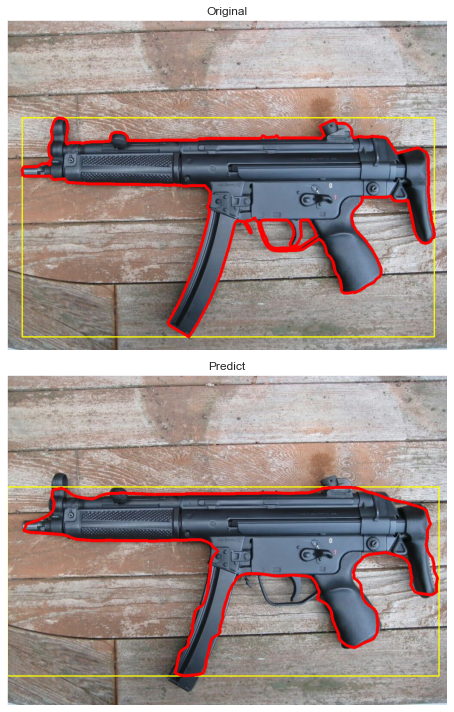

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


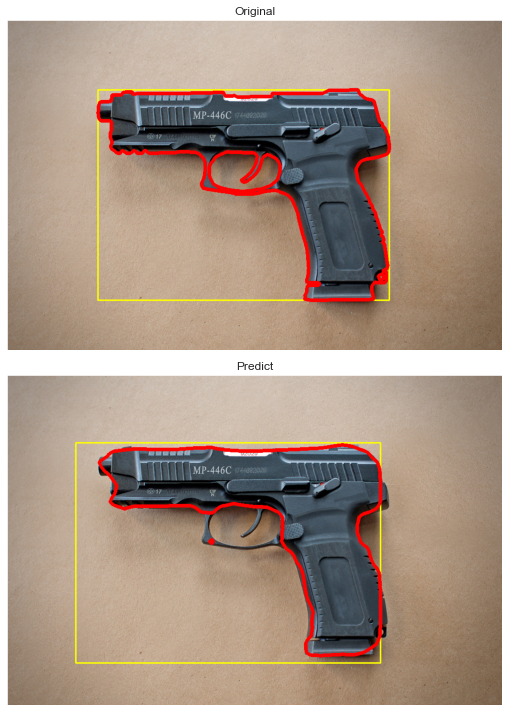

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


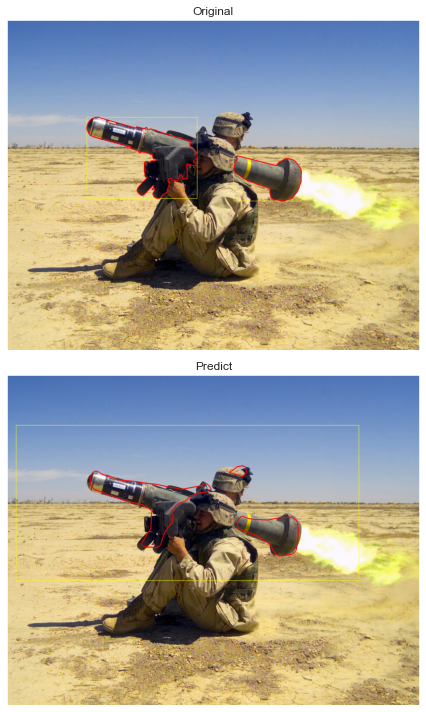

In [21]:
for _ in range(3):
    plot_mask(test_dataloader);